In [1]:
# Used this version of get_plasmid_inserts.py:
# !pip install git+https://github.com/nmateyko/labutils.git@5591e4ffd4a80c80687e5fe42b46392bd557d7e1

In [36]:
import Levenshtein
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.Align import PairwiseAligner
from collections import Counter
from sequence_analysis.utils import read_fastq, revcomp
from sequence_analysis.get_plasmid_inserts import get_insert, first_index_of_kmer

Define flanking regions (from pLX_TRC317; https://benchling.com/s/seq-3ND5VgqxGXSY3C0ScBOo?m=slm-ju7NQXGR4gPMzqh53eZx)

In [3]:
BC_UP = 'TTGGCTTTATATATCTTGTGGAAAGGACGA'
BC_DOWN = 'ACGCGTTAAGTCGACAATCAACCTCTGGAT'
GENE_UP = 'AGGTGTCGTGAGGCTAGCATCGATTGATCA'
GENE_DOWN = 'TGATATCGGTAAGCCTATCCCTAACCCTCT'
GENE_UP_2 = 'GAGTTTGGATCTTGGTTCATTCTCAAGCCT'
GENE_DOWN_2 = 'TAGTAATGAACTAGTCCGTAACTTGAAAGT'

Get plasmid reads from fastq

In [4]:
with open('Lab_w7p_1_MORF_Stable.fastq', 'r') as f:
    fastq_reader = read_fastq(f)
    reads = [read for read in fastq_reader]
print(f"{len(reads)} reads.")

1902 reads.


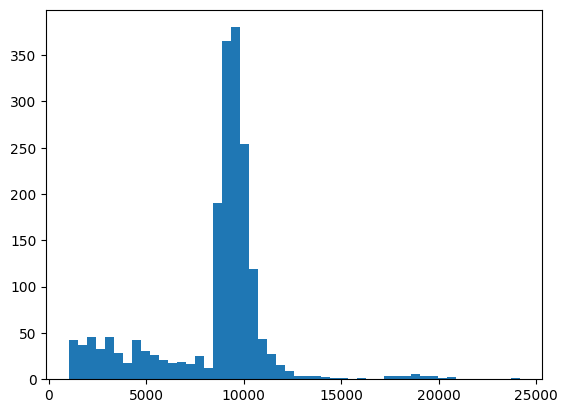

In [5]:
plt.hist([len(read[1]) for read in reads], bins=50)
plt.show()

Extract barcode and gene from each plasmid read.

In [6]:
extracted = []
for read in reads:
    barcode = get_insert(read, up=BC_UP, down=BC_DOWN, length=24, t=10, dist_func=Levenshtein.distance)
    gene = get_insert(read, up=GENE_UP_2, down=GENE_DOWN_2, length=10000, t=10, dist_func=Levenshtein.distance)
    if barcode and gene:
        extracted.append((barcode[1][0], gene[1][0]))
        # extracted.append(gene[1][0])
print(f"{len(extracted)} barcode-gene pairs.")

925 barcode-gene pairs.


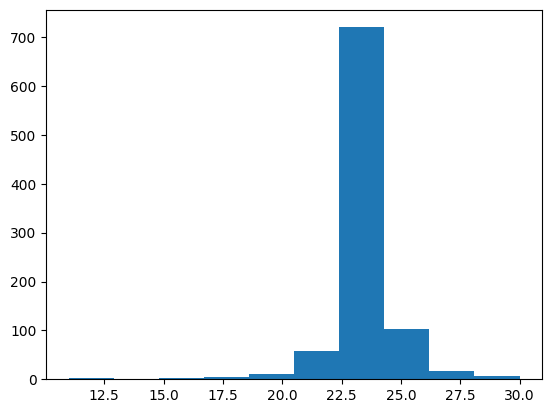

In [7]:
plt.hist([len(bc) for bc, gene in extracted])
plt.show()

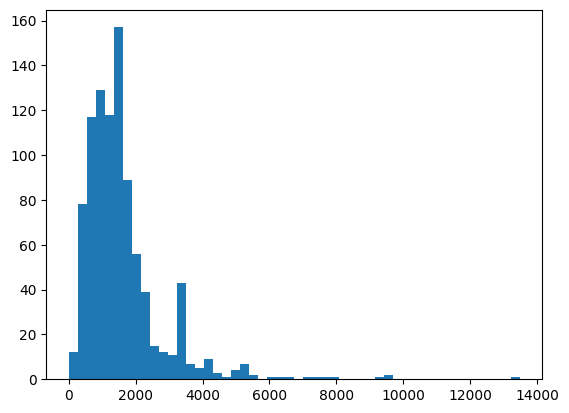

In [8]:
plt.hist([len(gene) for bc, gene in extracted], bins=50)
plt.show()

Read in barcode-gene pairings.

In [9]:
bc_gene_pairs = pd.read_csv('200102_tf_orf_library.csv')
bc_gene_pairs.head()

,Name,RefSeq Gene Name,RefSeq and Gencode ID,Barcode Sequence,ORF sequence,Full sequence,Notes 1,Notes 2
0,TFORF0001,HIF3A,"NM_022462,ENST00000244303",AGTCAAGACCCTCGGGCTCTGTGG,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
1,TFORF0002,HIF3A,"NM_152796,ENST00000472815",CAATTACACCACGTCTGCCTACTA,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
2,TFORF0003,HIF3A,"NM_152794,ENST00000300862",TTCAGACGTTTCGCGCCTGGAGCT,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
3,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",GATAACGCTAACCACAAGGTATTT,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN
4,TFORF0005,HIF3A,"NM_152795,ENST00000377670",CCACGCGAGCTAGACGATCGATGA,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,TTAATGTAGTCTTATGCAATACTCTTGTAGTCTTGCAACATGGTAA...,NaN,NaN


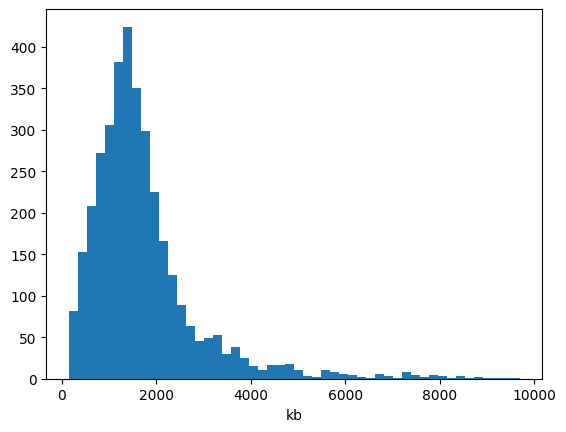

In [10]:
plt.hist([len(seq) for seq in bc_gene_pairs['ORF sequence']], bins=50)
plt.xlabel('kb')
plt.show()

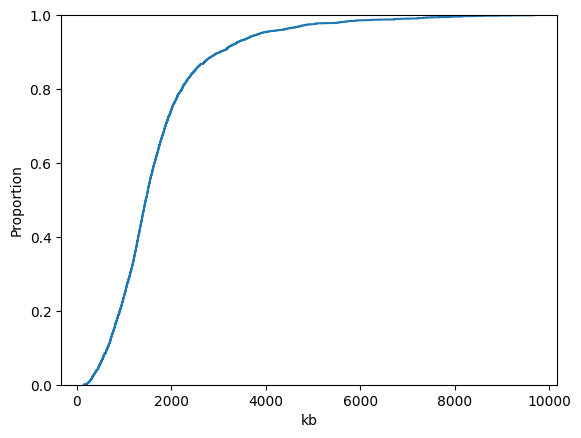

In [11]:
sns.ecdfplot([len(seq) for seq in bc_gene_pairs['ORF sequence']])
plt.xlabel('kb')
plt.show()

Find the minimum distance between barcodes.

In [12]:
min_dists = []
ref_barcodes = list(bc_gene_pairs['Barcode Sequence'])
for i, bc_1 in enumerate(ref_barcodes):
    min_dist = 100
    for j, bc_2 in enumerate(ref_barcodes):
        if i != j:
            dist = Levenshtein.distance(bc_1, bc_2)
            if dist < min_dist:
                min_dist = dist
    min_dists.append(min_dist)

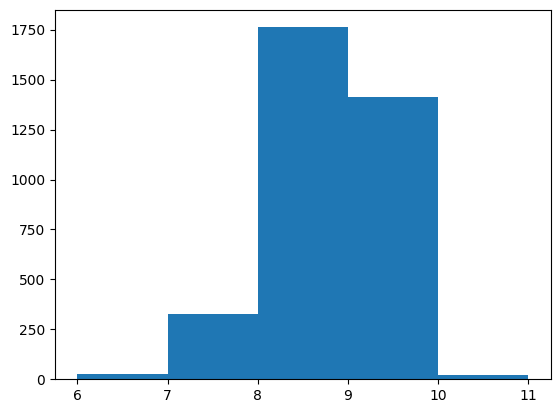

In [13]:
plt.hist(min_dists, bins=range(min(min_dists), max(min_dists) + 2))
plt.show()

A distance threshold of 6 for matching barcodes should be good; even though a few barcodes are this distance apart, the chance that one of the reads got the exact set of mutations that would transform one barcode into another is very unlikely.

Search for barcode match between extracted barcodes and reference barcodes. Tried with a distance of 6 and some extracted barcodes had more than 1 match, so reduced to a distance of 5.

In [14]:
bc_counts = {bc: 0 for bc in ref_barcodes}
for read_bc, _ in extracted:
    matches = []
    for ref_bc in ref_barcodes:
        if Levenshtein.distance(read_bc, ref_bc) < 6:
            matches.append(ref_bc)
    if len(matches) > 1:
        print("More than 1 match found!")
    elif len(matches):
        bc_counts[matches[0]] += 1

In [15]:
print(sum(bc_counts.values()))
print(max(bc_counts.values()))

884
4


(array([2.811e+03, 0.000e+00, 6.090e+02, 0.000e+00, 0.000e+00, 1.170e+02,
        0.000e+00, 1.100e+01, 0.000e+00, 2.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

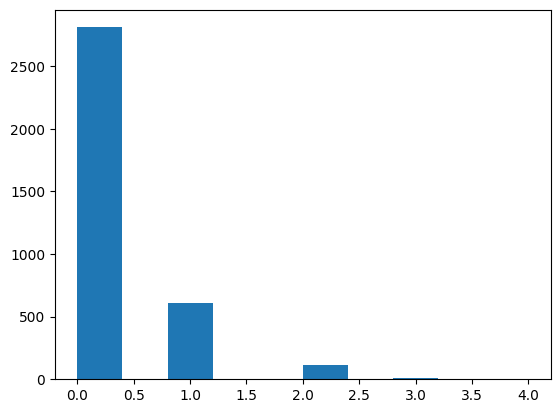

In [16]:
plt.hist(bc_counts.values())

In [37]:
QUERY = 'ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGGCATTTTGCCTTCCTGTTTTTGCTCACCCAGAAACGCTGGTGAAAGTAAAAGATG'

In [43]:
# concatenate each sequence to itself in case the read starts in the middle of the insert site
reads_concat = [(header, seq + seq, qual + qual) for header, seq, qual in reads]

# get first instance of upstream sequence and the sequence downstream of it
reindexed_reads = []
for header, seq, qual in reads_concat:
    index = first_index_of_kmer(seq, QUERY, 10, Levenshtein.distance)
    if index >= 0:
        reindexed_seq = seq[index:index + int(len(seq)/2)]
        reindexed_qual = qual[index:index + int(len(seq)/2)]
        reindexed_reads.append((header, reindexed_seq))
    else:
        index_rev = first_index_of_kmer(revcomp(seq), QUERY, 15, Levenshtein.distance)
        if index_rev >= 0:
            reindexed_seq = revcomp(seq)[index_rev:index_rev + int(len(seq)/2)]
            reindexed_qual = qual[::-1][index_rev:index_rev + int(len(seq)/2)]
            reindexed_reads.append((header, reindexed_seq))

In [44]:
print(len(reindexed_reads))

1572


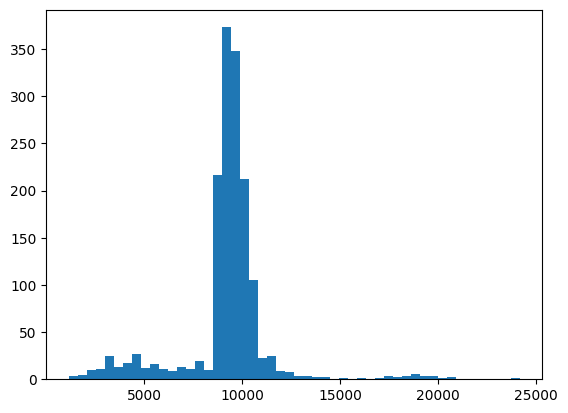

In [45]:
plt.hist([len(read[1]) for read in reindexed_reads], bins=50)
plt.show()

In [46]:
with open("MORF_GFP_ampR_start.txt", 'rt') as f:
    plasmid = f.readline()
plasmid = plasmid.upper()
print(len(plasmid))

9088
18176


In [70]:
aligner = PairwiseAligner(mode='global', match_score=2, mismatch_score=-1,
                          open_gap_score=-5, extend_gap_score=0)

In [71]:
def encode_alignment(ref, query):
    encoded = []
    for i, j in zip(ref, query):
        if i == j:
            encoded.append(0)
        elif i != j and '-' not in {i, j}:
            encoded.append(1)
        elif i == '-' and j != '-':
            encoded.append(2)
        elif i != '-' and j == '-':
            encoded.append(3)
    return encoded

def pad_lengths(d):
    max_len = max([len(v) for v in d.values()])
    for k, v in d.items():
        d[k] = v + [-1] * (max_len - len(v))
# d = {'a': [1, 2, 3], 'b': [1, 2]}
# pad_lengths(d)
# d

In [72]:
encoded_alignments = dict()
for read in reindexed_reads[:100]:
    alignments = aligner.align(plasmid, read[1])
    alignment = next(alignments)
    encoded = encode_alignment(alignment[0], alignment[1])
    encoded_alignments[read[0]] = encoded

In [73]:
pad_lengths(encoded_alignments)
alignments_df = pd.DataFrame.from_dict(encoded_alignments, orient='index')

AmpR starts at 0. E. coli ori ends at 1620. Gene begins at 6200.

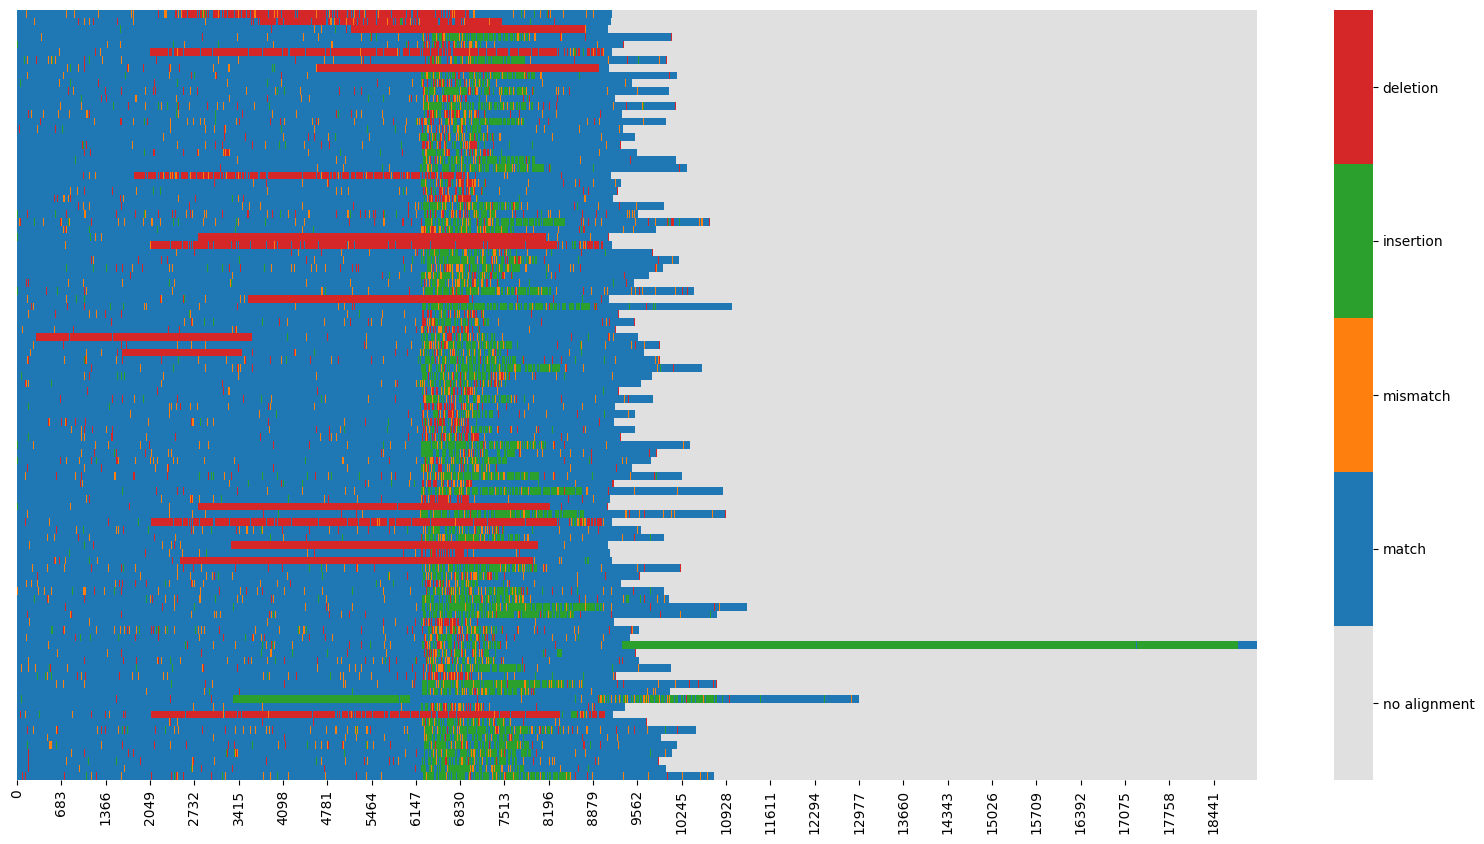

In [86]:
cmap = sns.color_palette(['#e0e0e0', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax = sns.heatmap(alignments_df, cmap=cmap)
plt.yticks([])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
colorbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
plt.gcf().set_size_inches(20, 10)
plt.show()